In [4]:
import numpy

In [5]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('../src')

from dataset import Tell1Dataset, DatasetTree
import dataset as DS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

Read dataset:

In [7]:
dataset = Tell1Dataset(r'../data/calibrations')

In [8]:
def sensor_histogram(data):
    x_data_list = []
    y_data_list = []
    for i,column in enumerate(data):
        y_data = list(data[column].values)
        y_data_list += y_data
        x_data_list += [i]*len(y_data)
    return x_data_list, y_data_list

In [9]:
bad_calibration = ["2011-03-07", "2012-08-02", "2012-07-30", "2012-08-01"]

In [10]:
header_list = [0, 32, 64, 96, 159, 191, 223, 255, 287, 319, 351, 383, 415, 447, 479, 511, 543, 575, 607, 639, 640, 672, 704, 736, 768, 800, 832, 864, 896, 928, 960, 992, 1024, 1056, 1088, 1120, 1183, 1215, 1247, 1279, 1311, 1343, 1375, 1407, 1439, 1471, 1503, 1535, 1567, 1599, 1631, 1663, 1664, 1696, 1728, 1760, 1792, 1824, 1856, 1888, 1920, 1952, 1984, 2016]
header_columns = ["channel{}".format(c) for c in header_list]

In [11]:
des = dataset.dfh['R'].df
des = des.drop(labels=header_columns,axis='columns')
des = des[((des.iloc[:,9:]>=50).sum(axis=1) == 0)]

In [12]:
badcals ={
     '2011-03-07':1.,
    '2012-08-02':3.,
    '2012-07-30': 10.,
    '2012-08-01':10.
}

In [13]:
for dt in des.datetime.unique():
    key = str(dt)[:10]
    val = badcals.get(key, 0.)
    des.loc[des.datetime==dt,'x'] = val

In [14]:
des.x.unique()

array([  0.,   1.,  10.,   3.])

In [15]:
wrong = des[des['datetime'].isin(bad_calibration)]
other = des[~des['datetime'].isin(bad_calibration)]
wrong = DS.DatasetTree.from_df(wrong)
other = DS.DatasetTree.from_df(other)

In [16]:
X = des.x.copy()

In [17]:
del des['x']

In [18]:
traindata = other.df.iloc[:,10:510].values

In [19]:
train2data = wrong.df.iloc[:,10:510].values
xtrain2data = wrong.df.x.values

In [20]:
X.values[:,np.newaxis].shape

(1186, 1)

In [21]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    sds = pm.Uniform("sds", 0, 0.75, shape=traindata.shape[1])
    centers = pm.Uniform("centers", 0,50, shape=traindata.shape[1])
    base = pm.Uniform('err',-30,40)
    pr = pm.Uniform('errp',0,0.5)
    rder = pm.Bernoulli('errb',p=pr)
    error = base*rder
    signal = pm.Normal("obs", mu=centers, sd=sds, observed=traindata)*(1-rder)
    observations = signal+error

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/net/people/plghawker/anaconda3/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/net/people/plghawker/anaconda3/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/net/people/plghawker/anaconda3/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 651, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 587, in pygpu.gpuarray.pygpu_init
pygpu.gpuarray.GpuArrayException: b'Could not load "libcuda.so": libcuda.so: cannot open shared object file: No such file or directory'


In [19]:
pm.backends.text.load('tracedump_r')

In [20]:
pm.traceplot(trace)

NameError: name 'trace' is not defined

In [ ]:
meancenters = trace['centers'].mean(axis=0)
meansds = trace['sds'].mean(axis=0)

In [21]:
post_pred_obs = pd.read_csv('post_pred.csv')

FileNotFoundError: File b'post_pred.csv' does not exist

In [22]:
data = pd.DataFrame(post_pred_obs)
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30], range=[[0,500],[0,30]],cmin=1)
axe.set_title('R-type module data, treshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

NameError: name 'post_pred_obs' is not defined

In [24]:
data = pd.DataFrame(traindata)
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30], range=[[0,500],[0,30]],cmin=1)
axe.set_title('R-type module data, treshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

In [25]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    x = pm.Uniform('x', 0,40, observed=xtrain2data[:,np.newaxis])
    k = pm.Uniform('k', -10,10,shape=traindata.shape[1])
    m = pm.Uniform('m', -10,10,shape=traindata.shape[1])
    observations = pm.Normal("obs", mu=meancenters+k*x, sd=meansds+m*x, observed=train2data)

In [26]:
with model:
    step = pm.Metropolis(vars=[k,m, observations])
    trace = pm.sample(32000, tune=16000,step=step)

100%|██████████| 48000/48000 [00:49<00:00, 979.46it/s]


In [27]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e932a08d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6e93225748>]], dtype=object)

In [28]:
with model:
    post_pred2 = pm.sample_ppc(trace, samples=8000)

100%|██████████| 8000/8000 [01:16<00:00, 105.21it/s]


In [29]:
postdata = np.mean(post_pred2['obs'], axis=0)

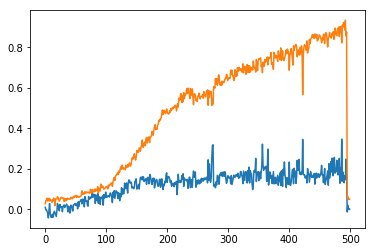

In [30]:
plt.plot(np.mean(trace['m'],axis=0))
plt.plot(np.mean(trace['k'],axis=0))

Text(0,0.5,'ADC')

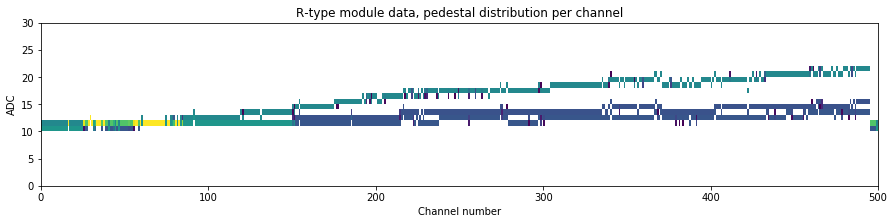

In [31]:
data = pd.DataFrame(postdata)
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30], range=[[0,500],[0,30]],cmin=1)
axe.set_title('R-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [32]:
simval = np.mean(post_pred_obs,axis=0)

Text(0,0.5,'ADC')

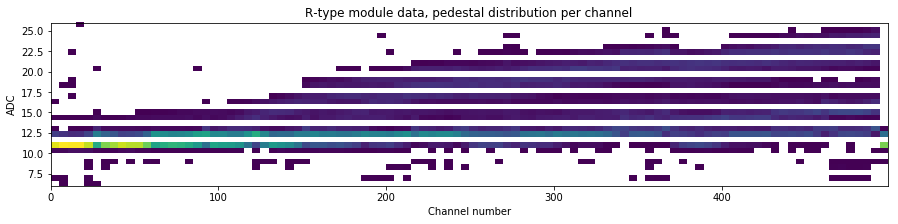

In [33]:
data = pd.DataFrame(train2data)
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[100,30],cmin=1)
axe.set_title('R-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [34]:
bad_calibration

['2011-03-07', '2012-08-02', '2012-07-30', '2012-08-01']

Text(0,0.5,'ADC')

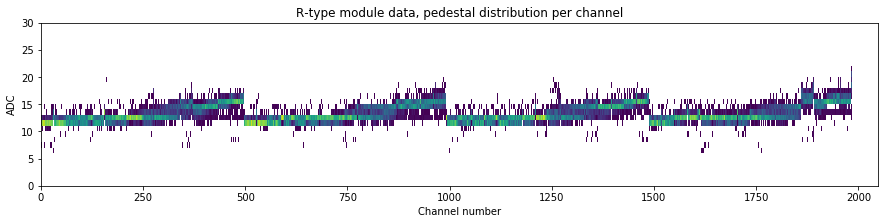

In [35]:
data = wrong.df[wrong.df.datetime=='2012-08-02'].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('R-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [36]:
kmeans = np.mean(trace['k'],axis=0)
mmeans = np.mean(trace['m'],axis=0)

In [37]:
model

In [38]:
pd.DataFrame(kmeans).to_csv('kmeans.cvs')
pd.DataFrame(mmeans).to_csv('mmeans.cvs')
pd.DataFrame(meancenters).to_csv('meancenters.cvs')
pd.DataFrame(meansds).to_csv('meansds.cvs')

In [44]:
import pymc3 as pm

with pm.Model() as model:
    x = 12.
    k = kmeans
    m = mmeans
    observations = pm.Normal("obs", mu=meancenters+k*x, sd=meansds+m*x, shape=500)

In [45]:
with model:
    step = pm.Metropolis(vars=[observations])
    trace3 = pm.sample(32000, tune=16000,step=step)

100%|██████████| 48000/48000 [00:10<00:00, 4538.62it/s]


In [46]:
trace3['obs'].shape

(32000, 500)

Text(0,0.5,'ADC')

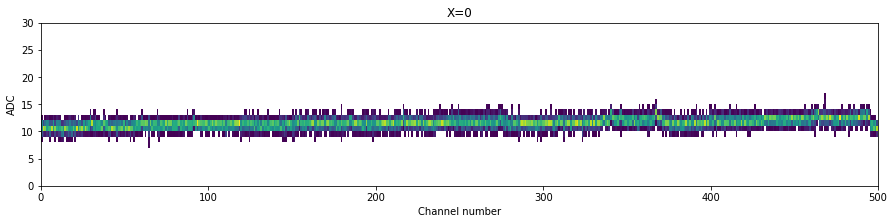

In [95]:
data = pd.DataFrame(trace3['obs'])
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30],range=[[0,500],[0,30]],cmin=1)#, range=[[0,100],[0,30]],cmin=1)
axe.set_title('X=0')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

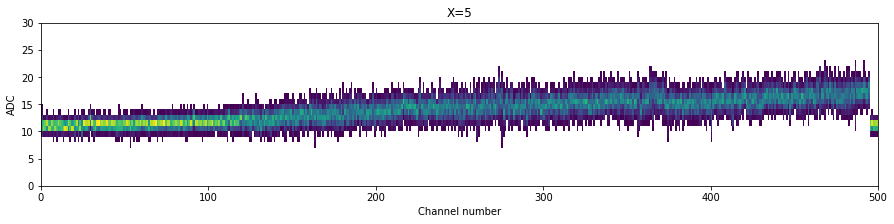

In [100]:
data = pd.DataFrame(trace3['obs'])
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30],range=[[0,500],[0,30]],cmin=1)#, range=[[0,100],[0,30]],cmin=1)
axe.set_title('X=5')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [106]:
data = pd.DataFrame(trace3['obs'])
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30],range=[[0,500],[0,30]],cmin=1)#, range=[[0,100],[0,30]],cmin=1)
axe.set_title('X=10')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

Text(0,0.5,'ADC')

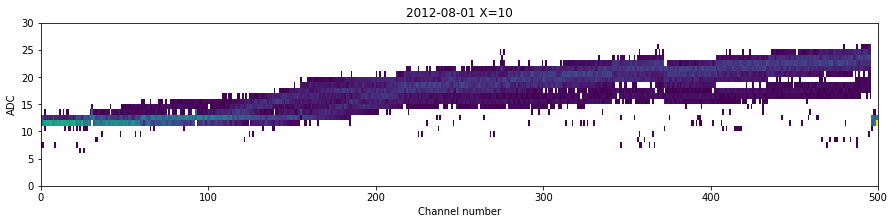

In [101]:
data = wrong.df[wrong.df.datetime=='2012-08-01'].iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30], range=[[0,500],[0,30]],cmin=1)
axe.set_title('2012-08-01 X=10')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0,0.5,'ADC')

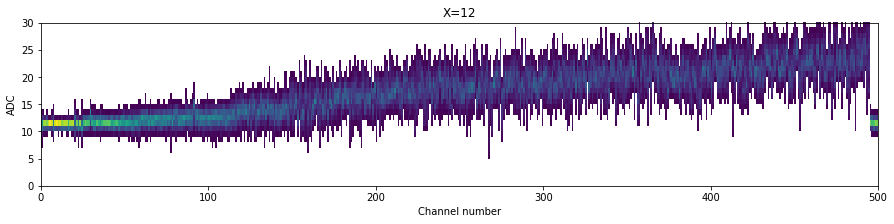

In [48]:
data = pd.DataFrame(trace3['obs'])
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[500,30],range=[[0,500],[0,30]],cmin=1)#, range=[[0,100],[0,30]],cmin=1)
axe.set_title('X=12')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')